<a href="https://colab.research.google.com/github/Andrelgesing/Fenics_Codes/blob/master/EdX_Course_HPFEM_assignment_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MOOC-HPFEM: Template notebook to be used to complete the assignments



The present notebook is meant to be a template for you to use while doing the assignments of the course. The first cell is meant to be run as-is and takes care of configuring the environment for you. The second cell is empty by default and is where you are supposed to paste the code you are given in the assignments so that you can modify and run it.

### FEniCS DFS formulation to run and modify yourself

In [0]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, update_display
import time
import dolfin.common.plotting as fenicsplot 

def plot_compact(u, t, stepcounter, QQ, pl, ax, soltit = "Velocity"): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    #u.set_allow_extrapolation(True)
    uEuclidnorm = project(sqrt(inner(u, u)), QQ)
    ax.cla()
    fig = plt.gcf()
    fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1)
    pp = plot(uEuclidnorm, cmap="coolwarm")
    plt.title("%s at t=%f" % (soltit, t)) # Plot norm of solution
    if t == 0:
      plt.axis(G)
      plt.colorbar(pp, shrink=0.5)
    plt.subplot(1, 2, 2);
    if t == 0:
      plot(QQ.mesh())
      plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

def plot_compact_static(u, QQ, label = "Velocity"): # Compact plot utility function
  pl, ax = plt.subplots();
  uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
  plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s" % (label)) # Plot norm of velocity
  plt.axis(G); plt.colorbar(pp, shrink=0.5); 
  plt.subplot(1, 2, 2);
  plot(QQ.mesh()); plt.title("Mesh") # Plot mesh
  plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)



# Heat Equation


elapsed CPU time:  5.589129999999997


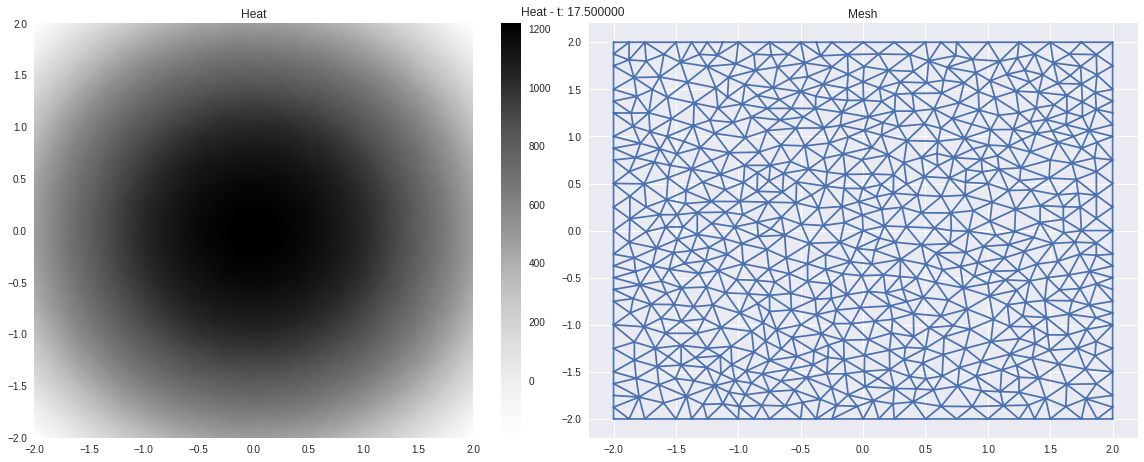

In [7]:
%matplotlib inline
#run /home/fenics/fenics-matplotlib.py
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output; 
import time
import logging; 
logging.getLogger('FFC').setLevel(logging.WARNING)

# Compact plot utility function
def plot_compact(u, t, stepcounter): 
    if stepcounter % 5 == 0:
        uEuclidnorm = project(u, V); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 6.5)
        plt.subplot(1, 2, 1); mplot_function(uEuclidnorm); plt.title("Heat") # Plot norm of velocity
        if t == 0.: plt.colorbar(); plt.axis(G)
        plt.subplot(1, 2, 2);
        if t == 0.: plt.triplot(mesh2triang(mesh)); plt.title("Mesh") # Plot mesh
        plt.suptitle("Heat - t: %f" % (t)); plt.tight_layout(); clear_output(wait=True);    


######## Important code begins here ########

# Define domain and mesh
XMIN, XMAX = -2., 2.; 
YMIN, YMAX = -2., 2.; 
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 20;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define finite element function space
degree = 1;
V = FunctionSpace(mesh, "CG", degree);

# Finite element functions
v = TestFunction(V); 
u = Function(V);

# Define boundary conditions
def boundary(x, on_boundary):
    return on_boundary

# Time parameters
theta = 1.0 # Implicit Euler
k = 0.5; # Time step
t, T = 0., 20.; # Start and end time

# Exact solution
k_coeff = 1
ue = Expression("exp(-(x[0]*x[0]+x[1]*x[1])/(4*a*t))/(4*pi*a*t)", degree = 2, a=k_coeff, t=1e-7, domain=mesh) 
u0 = ue;

bc = DirichletBC(V, ue, boundary)

# Inititalize time stepping
pl, ax = plt.subplots(); 
stepcounter = 0; 
timer0 = time.clock()

# Time-stepping loop
while t < T: 
    # Time scheme
    um = theta*u + (1.0-theta)*u0 
    
    # Weak form of the heat equation in residual form
    r = (u - u0)/k*v*dx + k_coeff*inner(grad(um), grad(v))*dx 
    
    # Solve the Heat equation (one timestep)
    solve(r==0, u, bc)  
    
    # Plot all quantities (see implementation above)
    plot_compact(u, t, stepcounter)
    
    # Shift to next timestep
    t += k; u0 = project(u, V); 
    ue.t = t;
    stepcounter += 1 
    
print ("elapsed CPU time: ", (time.clock() - timer0) )

# Fenics-Matplotlib

In [0]:
from dolfin import *
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def mplot_cellfunction(cellfn):
    C = cellfn.array()
    tri = mesh2triang(cellfn.mesh())
    return plt.tripcolor(tri, facecolors=C)

def mplot_function(f):
    mesh = f.function_space().mesh()
    if (mesh.geometry().dim() != 2):
        raise AttributeError('Mesh must be 2D')
    # DG0 cellwise function
    if f.vector().size() == mesh.num_cells():
        C = f.vector().array()
        return plt.tripcolor(mesh2triang(mesh), C)
    # Scalar function, interpolated to vertices
    elif f.value_rank() == 0:
        C = f.compute_vertex_values(mesh)
        return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    # Vector function, interpolated to vertices
    elif f.value_rank() == 1:
        w0 = f.compute_vertex_values(mesh)
        if (len(w0) != 2*mesh.num_vertices()):
            raise AttributeError('Vector field must be 2D')
        X = mesh.coordinates()[:, 0]
        Y = mesh.coordinates()[:, 1]
        U = w0[:mesh.num_vertices()]
        V = w0[mesh.num_vertices():]
        return plt.quiver(X,Y,U,V)

# Plot a generic dolfin object (if supported)
def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, Function):
        return mplot_function(obj)
    elif isinstance(obj, CellFunctionSizet):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionDouble):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionInt):
        return mplot_cellfunction(obj)
    elif isinstance(obj, Mesh):
        if (obj.geometry().dim() != 2):
            raise AttributeError('Mesh must be 2D')
        return plt.triplot(mesh2triang(obj), color='#808080')

    raise AttributeError('Failed to plot %s'%type(obj))

# Navier Stokes


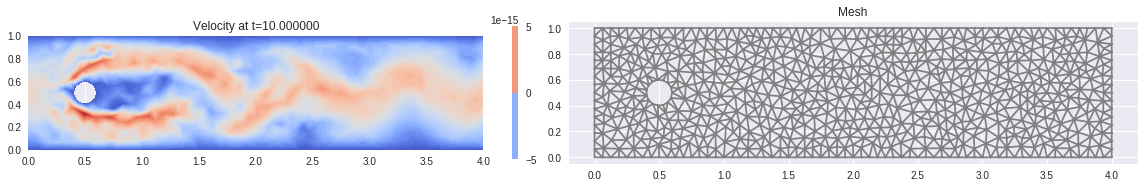

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


elapsed CPU time:  80.42964099999995


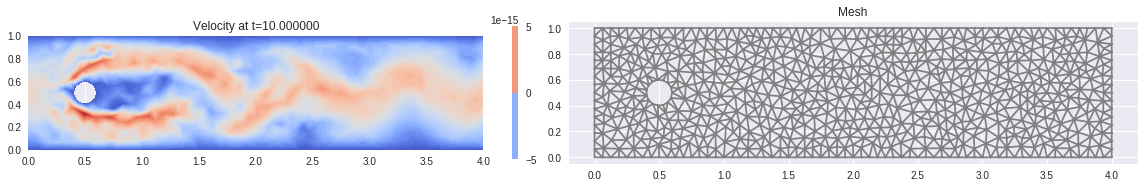

In [91]:
import matplotlib.pyplot as plt


def plot_compact(u, t, stepcounter, QQ, pl, ax, soltit = "Velocity"): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    #u.set_allow_extrapolation(True)
    uEuclidnorm = project(sqrt(inner(u, u)), QQ)
    ax.cla()
    fig = plt.gcf()
    fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1)
    pp = plot(uEuclidnorm, cmap="coolwarm")
    plt.title("%s at t=%f" % (soltit, t)) # Plot norm of solution
    if t == 0:
      plt.axis(G)
      plt.colorbar(pp, shrink=0.5)
    plt.subplot(1, 2, 2);
    if t == 0:
      plot(QQ.mesh())
      plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

# Generate domain and mesh
XMIN = 0.; 
XMAX = 4.; 
YMIN = 0; 
YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
eps = 1e-5

mresolution=30

SEGMENTS = 15;
circle = Circle(Point(.5, .5), .1, SEGMENTS)

mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - circle, mresolution)
# FEM function spaces and functions
degree=1
Qe = FiniteElement("CG", mesh.ufl_cell(), degree)
Q = FunctionSpace(mesh,Qe);

Ve = VectorElement("CG", mesh.ufl_cell(), degree)
V = FunctionSpace(mesh,Ve);

TH = MixedElement([Ve,Qe])
W = FunctionSpace(mesh, TH)

h = 0.5*CellDiameter(mesh);
(v, q) = TestFunctions(W);
w = Function(W); 
(u, p) = (as_vector((w[0], w[1])), w[2]); 
u0 = Function(V)

# Inlet velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, degree=degree+1) 
# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, degree=degree) 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, degree=degree)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, degree=degree)

# Timestep, viscosity and stabilization parameters
k = 0.1; 
d = .2*h**(3./2.) 

# Time interval and penalty parameter
t, T = 0., 10.; 
gamma = 10*1./h 

pl, ax = None, None; 

# Initialize time stepping
stepcounter = 0; 
timer0 = time.clock()
pl, ax = None, None; 

# Time stepping method
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
# Time-stepping loop
while t < T: 
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)  

    # Visualize the solution
    pl, ax=plot_compact(u0, t, stepcounter, Q, pl, ax, soltit="Velocity") # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k; 
    stepcounter += 1; 
    u0 = project(u, V); 

print("elapsed CPU time: ", (time.clock() - timer0))

In [96]:


# Mark circle region
psimarker = Expression("pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < .1 + eps ? 1. : 0.", eps=eps, degree=2)
# Calculate drag
n = FacetNormal(mesh)
M1 = psimarker*p*n[0]*ds
drag_force = assemble(M1)
print("Draf force is:", drag_force)


Draf force is: 0.11835231892306064


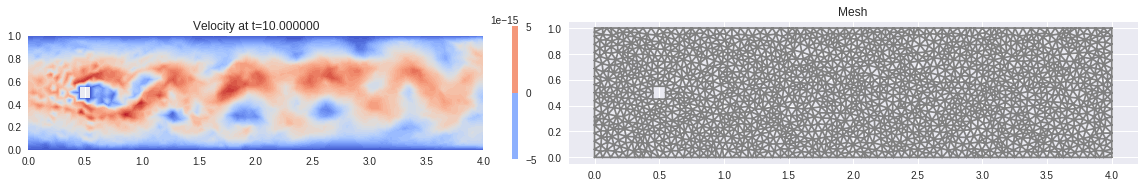

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


elapsed CPU time:  152.87921299999994


INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
DEBUG:UFL:Blocks of each mode: 
  1	full


Draf force is: 0.08290549481171502


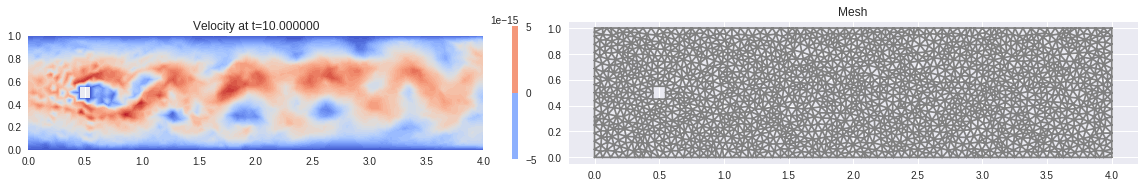

In [100]:
import matplotlib.pyplot as plt


def plot_compact(u, t, stepcounter, QQ, pl, ax, soltit = "Velocity"): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    #u.set_allow_extrapolation(True)
    uEuclidnorm = project(sqrt(inner(u, u)), QQ)
    ax.cla()
    fig = plt.gcf()
    fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1)
    pp = plot(uEuclidnorm, cmap="coolwarm")
    plt.title("%s at t=%f" % (soltit, t)) # Plot norm of solution
    if t == 0:
      plt.axis(G)
      plt.colorbar(pp, shrink=0.5)
    plt.subplot(1, 2, 2);
    if t == 0:
      plot(QQ.mesh())
      plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

# Generate domain and mesh
XMIN = 0.; 
XMAX = 4.; 
YMIN = 0; 
YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
eps = 1e-5

mresolution=50

SEGMENTS = 15;
square = Rectangle(Point(.45, .45),Point(.55, .55))
#circle = Circle(Point(.5, .5), .1, SEGMENTS)

mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - square, mresolution)
# FEM function spaces and functions
degree=1
Qe = FiniteElement("CG", mesh.ufl_cell(), degree)
Q = FunctionSpace(mesh,Qe);

Ve = VectorElement("CG", mesh.ufl_cell(), degree)
V = FunctionSpace(mesh,Ve);

TH = MixedElement([Ve,Qe])
W = FunctionSpace(mesh, TH)

h = 0.5*CellDiameter(mesh);
(v, q) = TestFunctions(W);
w = Function(W); 
(u, p) = (as_vector((w[0], w[1])), w[2]); 
u0 = Function(V)

# Inlet velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, degree=degree+1) 
# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, degree=degree) 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, degree=degree)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, degree=degree)

# Timestep, viscosity and stabilization parameters
k = 0.1; 
d = .2*h**(3./2.) 

# Time interval and penalty parameter
t, T = 0., 10.; 
gamma = 10*1./h 

pl, ax = None, None; 

# Initialize time stepping
stepcounter = 0; 
timer0 = time.clock()
pl, ax = None, None; 

# Time stepping method
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
# Time-stepping loop
while t < T: 
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)  

    # Visualize the solution
    pl, ax=plot_compact(u0, t, stepcounter, Q, pl, ax, soltit="Velocity") # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k; 
    stepcounter += 1; 
    u0 = project(u, V); 

print("elapsed CPU time: ", (time.clock() - timer0))
# Mark suqare region
psimarker1 = Expression("x[0] > 0.45 - eps && x[0] < 0.45 + eps && x[1] > 0.45 - eps && x[1] < 0.55 + eps", eps=eps, degree=degree)
psimarker2 = Expression("x[0] > 0.55 - eps && x[0] < 0.55 + eps && x[1] > 0.45 - eps && x[1] < 0.55 + eps", eps=eps, degree=degree)
psimarker3 = Expression("x[0] > 0.45 - eps && x[0] < 0.55 + eps && x[1] > 0.55 - eps && x[1] < 0.55 + eps", eps=eps, degree=degree)
psimarker4 = Expression("x[0] > 0.45 - eps && x[0] < 0.55 + eps && x[1] > 0.45 - eps && x[1] < 0.45 + eps", eps=eps, degree=degree)
psimarker = psimarker1 + psimarker2 + psimarker3 + psimarker4
# Calculate drag
n = FacetNormal(mesh)
M1 = psimarker*p*n[0]*ds
drag_force = assemble(M1)
print("Draf force is:", drag_force)

In [110]:
# Mark suqare region
psimarker1 = Expression("x[0] > 0.45 - eps && x[0] < 0.45 + eps && x[1] > 0.45 - eps && x[1] < 0.55 + eps", eps=eps, degree=degree)
psimarker2 = Expression("x[0] > 0.55 - eps && x[0] < 0.55 + eps && x[1] > 0.45 - eps && x[1] < 0.55 + eps", eps=eps, degree=degree)
psimarker3 = Expression("x[0] > 0.45 - eps && x[0] < 0.55 + eps && x[1] > 0.55 - eps && x[1] < 0.55 + eps", eps=eps, degree=degree)
psimarker4 = Expression("x[0] > 0.45 - eps && x[0] < 0.55 + eps && x[1] > 0.45 - eps && x[1] < 0.45 + eps", eps=eps, degree=degree)
psimarker = psimarker1 + psimarker2 + psimarker4 + psimarker3 
# Calculate drag
n = FacetNormal(mesh)
M1 = psimarker*p*n[0]*ds
drag_force = assemble(M1)
print("Draf force is:", drag_force)

Draf force is: 0.08290549481171502


# Wave Equation


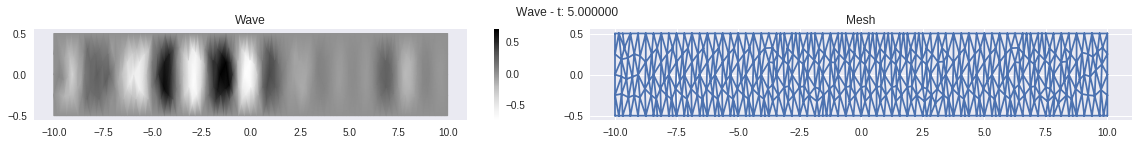

In [79]:
%matplotlib inline                                                                                                                                                                                                                                            
                                                                                                                                                                                                                      
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output; 
import time
import logging; logging.getLogger('FFC').setLevel(logging.WARNING)

import numpy as np

dolfin.set_log_level(False)

# Compact plot utility function
def plot_compact(w, t, stepcounter): 
    if stepcounter % 5 == 0:
        #u, v = w.split()
        #uEuclidnorm = project(u, W); 
        
        wEuclidnorm = project(w, W);
        uEuclidnorm, vEuclidnorm = wEuclidnorm.split()
        ax.cla(); 
        fig = plt.gcf();
        fig.set_size_inches(16, 2)
        
        # Plot norm of velocity
        plt.subplot(1, 2, 1); 
        #mplot_function(u); 
        mplot_function(uEuclidnorm);
        plt.title("Wave") 
        plt.colorbar(); 
        # plt.axis(G)
        
        # Plot mesh
        plt.subplot(1, 2, 2);
        plt.triplot(mesh2triang(mesh)); 
        plt.title("Mesh")
        plt.suptitle("Wave - t: %f" % (t)); 
        plt.tight_layout(); 
        clear_output(wait=True); 
        display(pl)   

# Define domain and mesh
XMIN, XMAX = -10., 10.;
YMIN, YMAX = -0.5, 0.5;
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 50;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define function spaces and functions
Q = FiniteElement("CG", mesh.ufl_cell(), 1) 
W = FunctionSpace(mesh, Q * Q); 
h = CellDiameter(mesh);
(p, q) = TestFunctions(W); 
w = Function(W); 
(u, v) = (w[0], w[1]);
u0 = Function(W); 
v0 = Function(W);

# Time interval and time step
t, T = 0., 5.;
k = 0.05;
a = 20;

# Define the Dirichlet boundary   
def boundary(x, on_boundary):                                                                                                                                                                                                 
    return on_boundary

# Initial solution
option = 1;
if option==0:
    ue = Expression("(1-pow(a*t-x[0],2))*exp(-pow(a*t-x[0],2)) + (1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", degree = 2, a=a, t=0, domain=mesh);
    ve = Expression("2*a*(a*t-x[0])*(pow(a*t-x[0],2)-2)*exp(-pow(a*t-x[0],2)) + 2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", degree = 2, a=a, t=0, domain=mesh)
if option==1:
    ue = Expression("(1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", degree = 2, a=a, t=0, domain=mesh);
    ve = Expression("2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", degree = 2, a=a, t=0, domain=mesh)
F = FunctionSpace(mesh, Q)
# Boundary conditions
bcu = DirichletBC(W.sub(0), ue, boundary)
bcv = DirichletBC(W.sub(1), ve, boundary)
bcs = [bcu, bcv];

# Initial solution
u0 = ue;
v0 = ve;

# Time scheme parameter
theta = 0.5;

# Time-stepping loop    
while t <= T:
    # Weak form of wave equation
    vm = theta*v + (1.0-theta)*v0;
    um = theta*u + (1.0-theta)*u0;
    ru=(u-u0)/k*p*dx - vm*p*dx
    rv=(v-v0)/k*q*dx + a*a*inner(grad(um),grad(q))*dx
    r = ru + rv;
    ue.t = t;
    ve.t = t;
    
    # Solve the wave equation (one time step)
    solve(r==0, w, bcs);
    
    # Visualize the solution
    pl, ax = plt.subplots();
    plot_compact(w, t, 0)
    plt.close();
    
    # Shift to next timestep                                                     
    w0 = project(w, W);
    (u0, v0) = w0.split();
    t += k;